# Spectral Clustering on Non-Convex Data
 Presented by: Yosser Fhal
 
 This notebook demonstrates Spectral Clustering for grouping non-convex data (e.g., circular or complex shapes).

 It follows the concepts from the provided presentation, with visualizations to help you learn.

# Why Spectral Clustering?
 - Traditional clustering (e.g., K-Means) assumes spherical (convex) clusters and uses distance.
 - Spectral Clustering uses graph connectivity (relationships) via eigenvalues/eigenvectors, making it ideal for non-convex shapes like circles or moons.
- Example: In social networks, people in the same community might not be directly close but connected via friends.

*1. Import necessary libraries*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly
import plotly.graph_objs as go
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh  # For computing eigenvalues/eigenvectors of sparse matrices
import warnings
warnings.filterwarnings('ignore')

# Manual Spectral Clustering Function
 This function implements Spectral Clustering manually:
 1. Build affinity matrix using k-nearest neighbors.
 2. Compute degree matrix and Laplacian.
 3. Find eigenvectors of Laplacian.
 4. Cluster the eigenvectors using K-Means.


In [2]:
def manual_spectral_clustering(X, n_clusters=2, n_neighbors=15, random_state=42):
    # Step 1: Build affinity matrix (k-nearest neighbors)
    A = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    A = A.toarray()  # Convert to dense for simplicity (for large datasets, keep sparse)
    A = (A + A.T) / 2  # Symmetrize (undirected graph)
    
    # Step 2: Degree matrix D
    D = np.diag(np.sum(A, axis=1))
    
    # Step 3: Laplacian L = D - A
    L = D - A
    
    # Step 4: Compute eigenvectors (smallest eigenvalues first)
    # We need the first n_clusters eigenvectors (excluding the trivial one with eigenvalue 0)
    eigenvalues, eigenvectors = eigsh(L, k=n_clusters+1, which='SM')  # SM: smallest magnitude
    eigenvectors = eigenvectors[:, 1:n_clusters+1]  # Skip the first eigenvector (all ones)
    
    # Step 5: Normalize rows of eigenvectors (optional, but common)
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)
    
    # Step 6: Cluster the rows of eigenvectors using K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=random_state)
    labels = kmeans.fit_predict(eigenvectors)
    
    return labels


# Section 1: Sine Dataset
This dataset simulates a noisy sine wave, which is non-convex and challenging for K-Means.


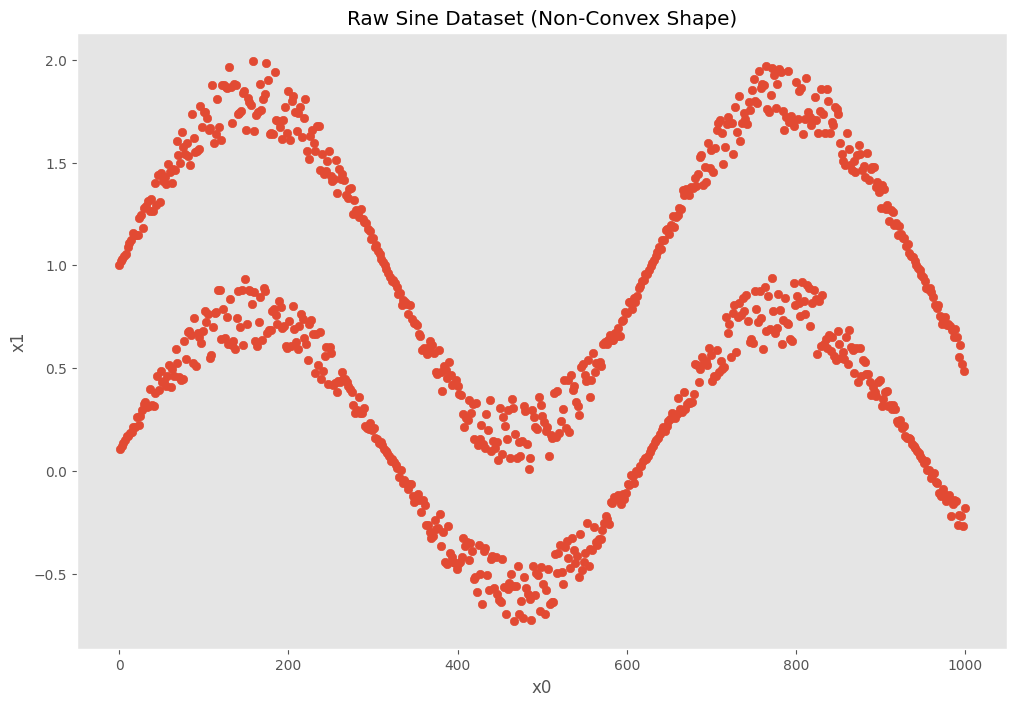

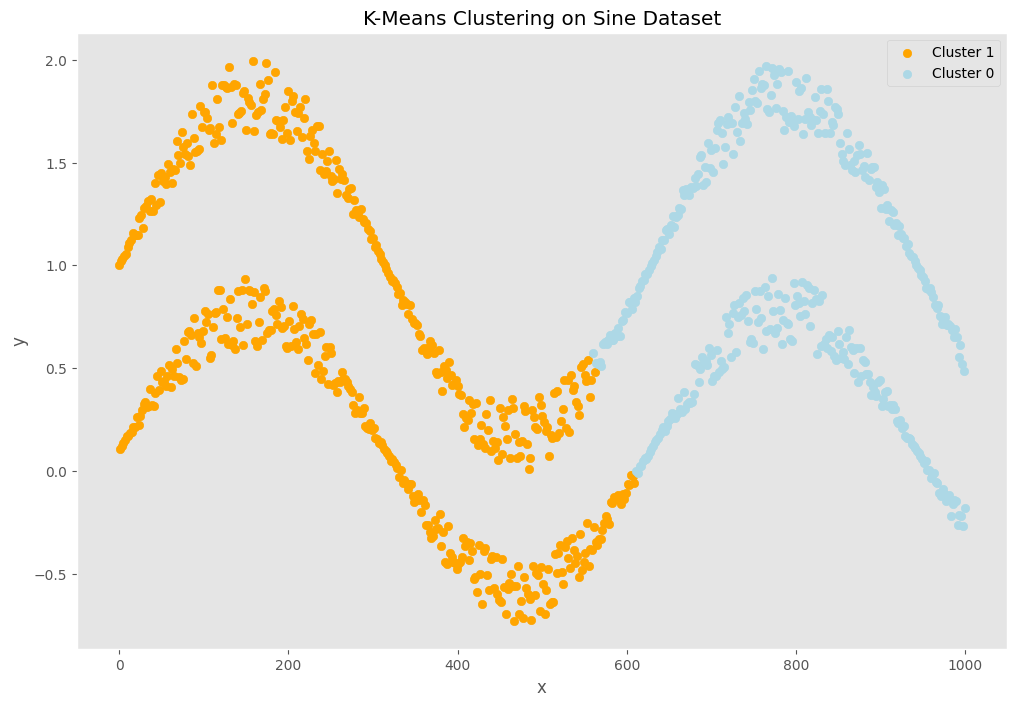

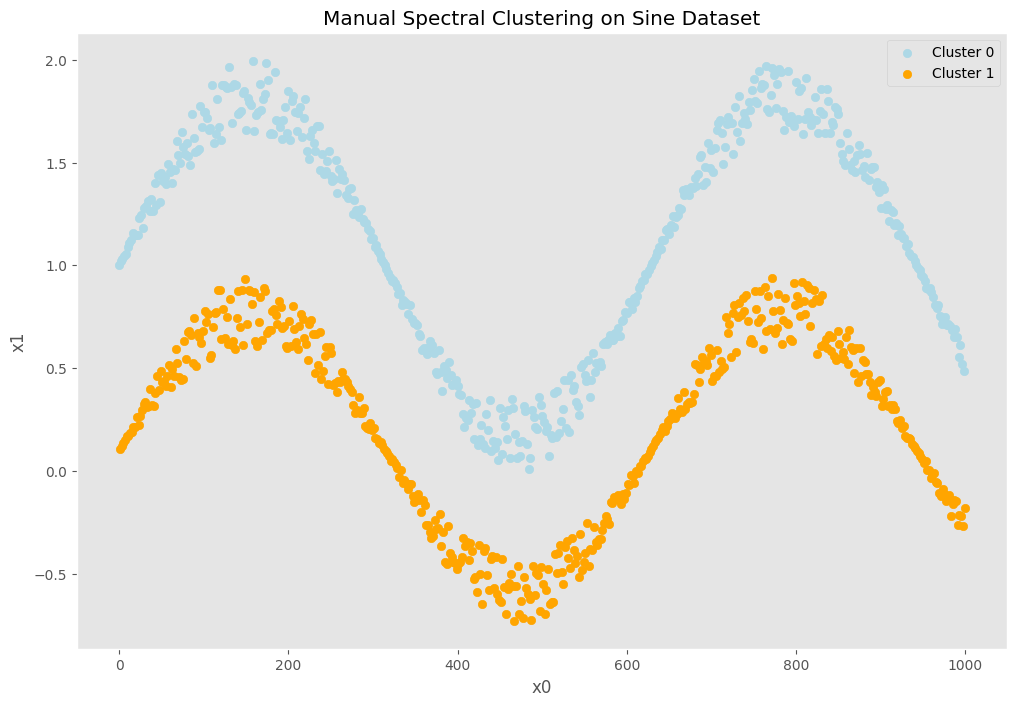

Silhouette Score - K-Means: 0.419
Silhouette Score - Manual Spectral: 0.182


In [3]:

# Generate the sine dataset
nb_samples = 1000
X = np.zeros(shape=(nb_samples, 2))
sine_dataset = pd.DataFrame(X)

for i in range(nb_samples):
    X[i, 0] = float(i)
    if i % 2 == 0:
        X[i, 1] = 1.0 + (np.random.uniform(0.65, 1.0)) * np.sin(float(i) / 100.0)
    else:
        X[i, 1] = 0.1 + (np.random.uniform(0.5, 0.85)) * np.sin(float(i) / 100.0)

# Visualize the raw sine data
fig = plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Raw Sine Dataset (Non-Convex Shape)')
plt.grid()
plt.show()

# Standardize the data
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

# Fit K-Means with 2 clusters
kmeans_md = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_scaled)

# Append cluster labels
sine_dataset.columns = ['x', 'y']
sine_dataset['kmeans_cluster'] = kmeans_md.labels_

# Visualize K-Means results
colors = ['lightblue', 'orange']
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['kmeans_cluster'].unique():
    temp = sine_dataset[sine_dataset['kmeans_cluster'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Manual Spectral Clustering with 2 clusters (replicating sklearn's results)
spectral_labels = manual_spectral_clustering(X_scaled, n_clusters=2, n_neighbors=15, random_state=42)
sine_dataset['spectral_clusters'] = spectral_labels

# Visualize Manual Spectral Clustering results
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Manual Spectral Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Evaluate and Compare Clusters
sil_kmeans = silhouette_score(X_scaled, kmeans_md.labels_)
sil_spectral = silhouette_score(X_scaled, spectral_labels)
print(f"Silhouette Score - K-Means: {sil_kmeans:.3f}")
print(f"Silhouette Score - Manual Spectral: {sil_spectral:.3f}")
# Spectral should have a higher score due to better handling of non-convex shapes.

# Interactive Plotly Visualization for Sine Dataset
traces = []
for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors[c], size=8), 
                       name=f'Cluster {c}')
    traces.append(trace)

layout = go.Layout(title='Interactive Manual Spectral Clustering on Sine Dataset',
                   xaxis=dict(title='x'),
                   yaxis=dict(title='y'),
                   showlegend=True)
fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig)



# Section 2: Enhanced Circle Dataset
We enhance the raw circle dataset by generating three concentric circles (instead of two) with added noise.

This makes it more complex and non-convex, better demonstrating Spectral Clustering's advantages over K-Means.

Manual Spectral Clustering is set to 3 clusters to match.

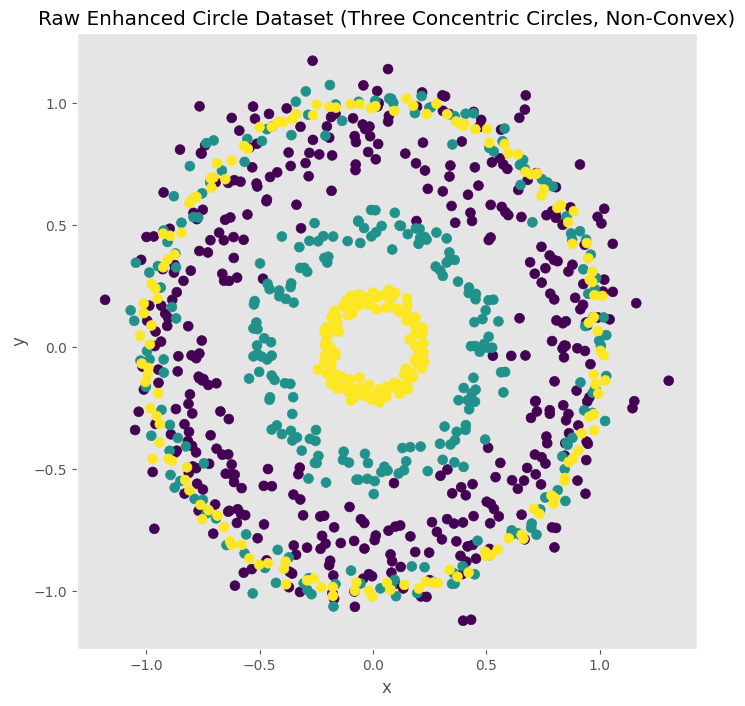

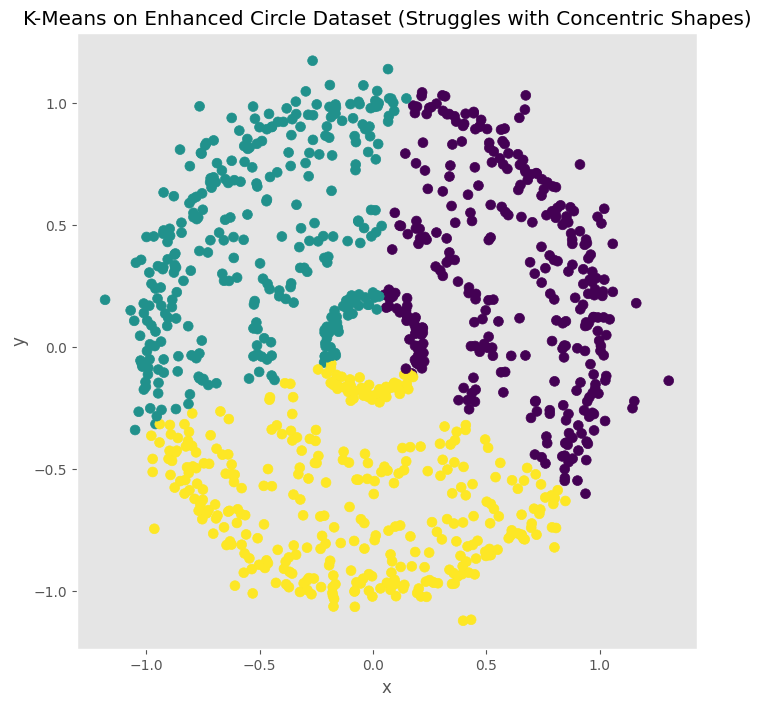

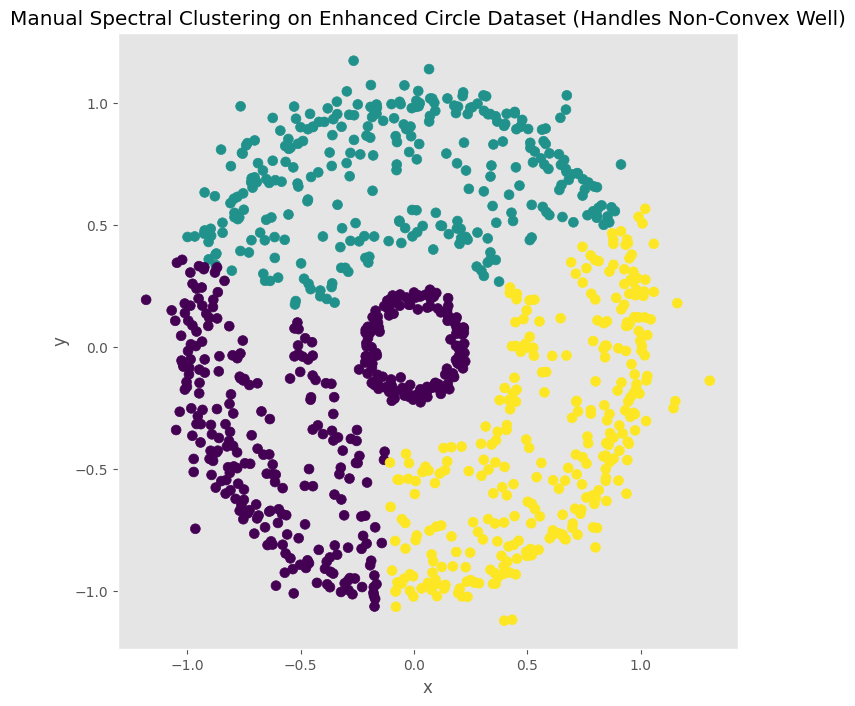

Silhouette Score (Circles) - K-Means: 0.362
Silhouette Score (Circles) - Manual Spectral: 0.333


In [ ]:
# Generate enhanced circle dataset (three circles)
# Outer circle
X_outer, _ = make_circles(n_samples=400, noise=0.1, factor=0.8, random_state=42)
# Middle circle
X_middle, _ = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=43)
# Inner circle
X_inner, _ = make_circles(n_samples=300, noise=0.02, factor=0.2, random_state=44)

# Combine and add true labels (0: outer, 1: middle, 2: inner)
X_circles = np.vstack([X_outer, X_middle, X_inner])
y_true_circles = np.hstack([np.zeros(400), np.ones(300), np.full(300, 2)])
circle_dataset = pd.DataFrame(X_circles, columns=['x', 'y'])
circle_dataset['true_labels'] = y_true_circles

# Visualize raw enhanced circle data
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_true_circles, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Enhanced Circle Dataset (Three Concentric Circles, Non-Convex)')
plt.grid()
plt.show()

# Standardize
scaler_circles = MinMaxScaler().fit(X_circles)
X_circles_scaled = scaler_circles.transform(X_circles)

# Fit K-Means on circles (with 3 clusters to match)
kmeans_circles = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42).fit(X_circles_scaled)
circle_dataset['kmeans_cluster'] = kmeans_circles.labels_

# Visualize K-Means on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=kmeans_circles.labels_, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means on Enhanced Circle Dataset (Struggles with Concentric Shapes)')
plt.grid()
plt.show()

# Manual Spectral Clustering on circles (3 clusters)
spectral_labels_circles = manual_spectral_clustering(X_circles_scaled, n_clusters=3, n_neighbors=15, random_state=42)
circle_dataset['spectral_clusters'] = spectral_labels_circles

# Visualize Manual Spectral Clustering on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=spectral_labels_circles, cmap='viridis', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Manual Spectral Clustering on Enhanced Circle Dataset (Handles Non-Convex Well)')
plt.grid()
plt.show()

# Evaluate Clusters for Circles
sil_kmeans_circles = silhouette_score(X_circles_scaled, kmeans_circles.labels_)
sil_spectral_circles = silhouette_score(X_circles_scaled, spectral_labels_circles)
print(f"Silhouette Score (Circles) - K-Means: {sil_kmeans_circles:.3f}")
print(f"Silhouette Score (Circles) - Manual Spectral: {sil_spectral_circles:.3f}")
# Spectral should outperform K-Means significantly here.

# Interactive Plotly for Circles
colors_circles = ['lightblue', 'orange', 'green']
traces_circles = []
for c in circle_dataset['spectral_clusters'].unique():
    temp = circle_dataset[circle_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors_circles[c], size=8), 
                       name=f'Cluster {c}')
    traces_circles.append(trace)

layout_circles = go.Layout(title='Interactive Manual Spectral Clustering on Enhanced Circle Dataset',
                           xaxis=dict(title='x'),
                           yaxis=dict(title='y'),
                           showlegend=True)
fig_circles = go.Figure(data=traces_circles, layout=layout_circles)
plotly.offline.iplot(fig_circles)


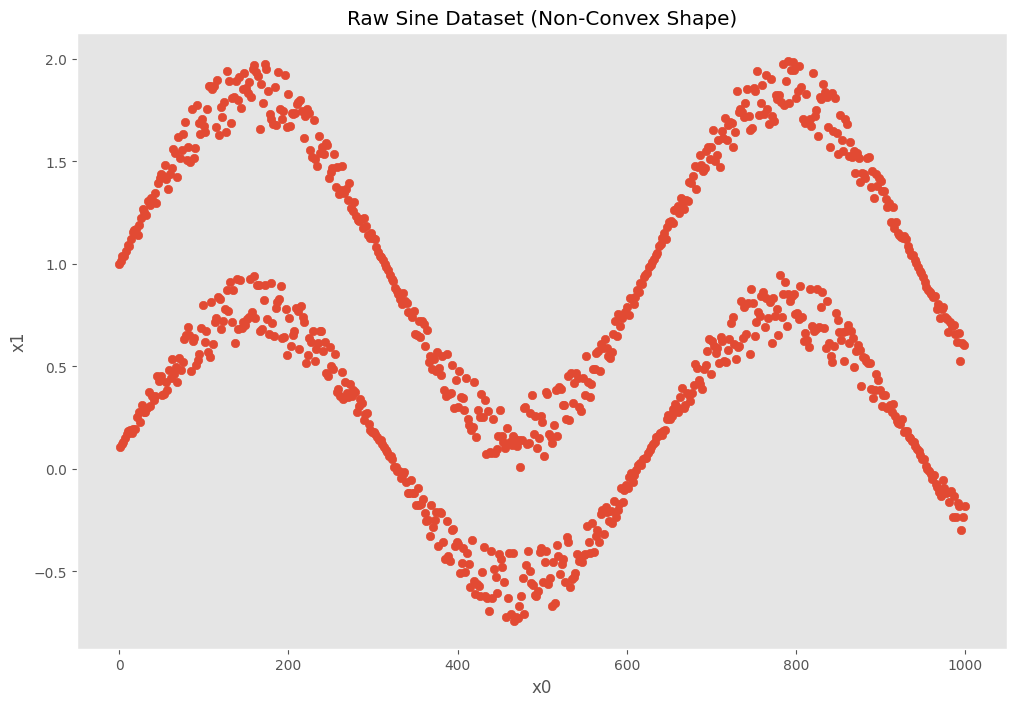

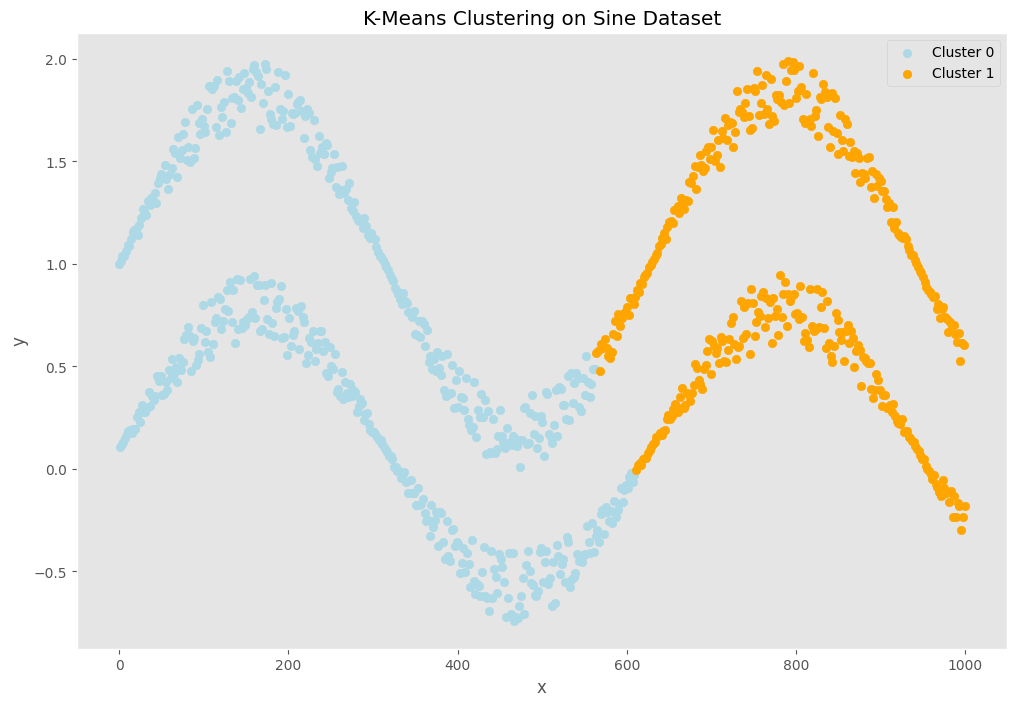

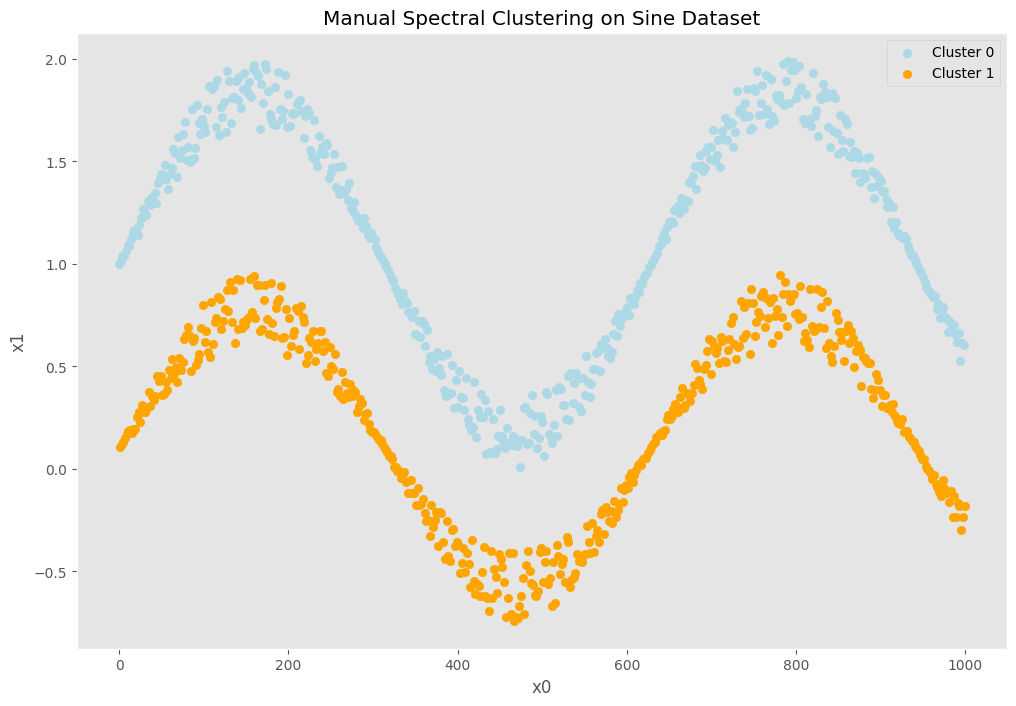

Silhouette Score - K-Means: 0.417
Silhouette Score - Manual Spectral: 0.181


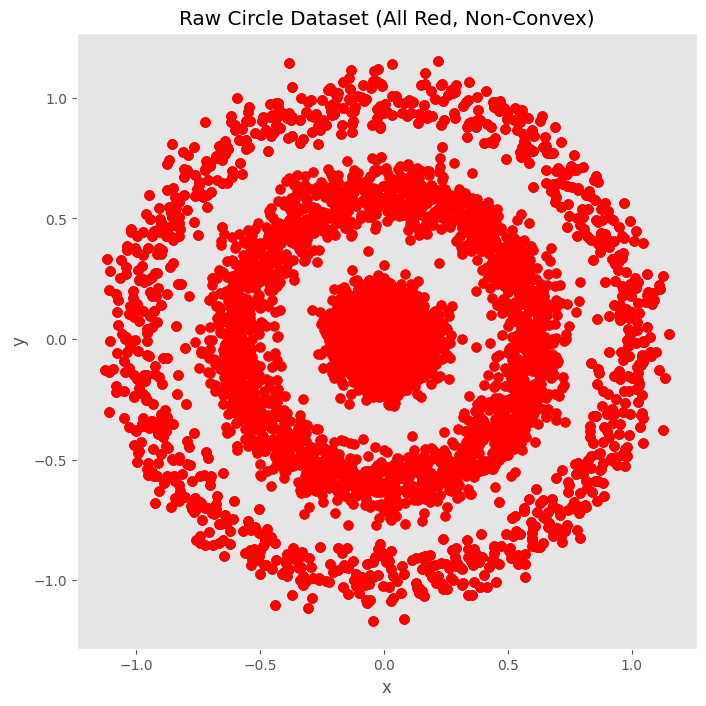

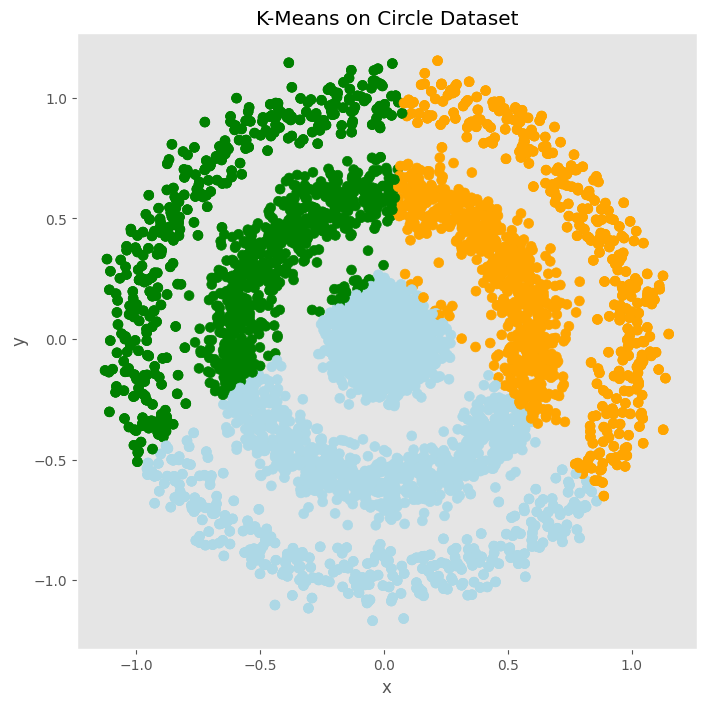

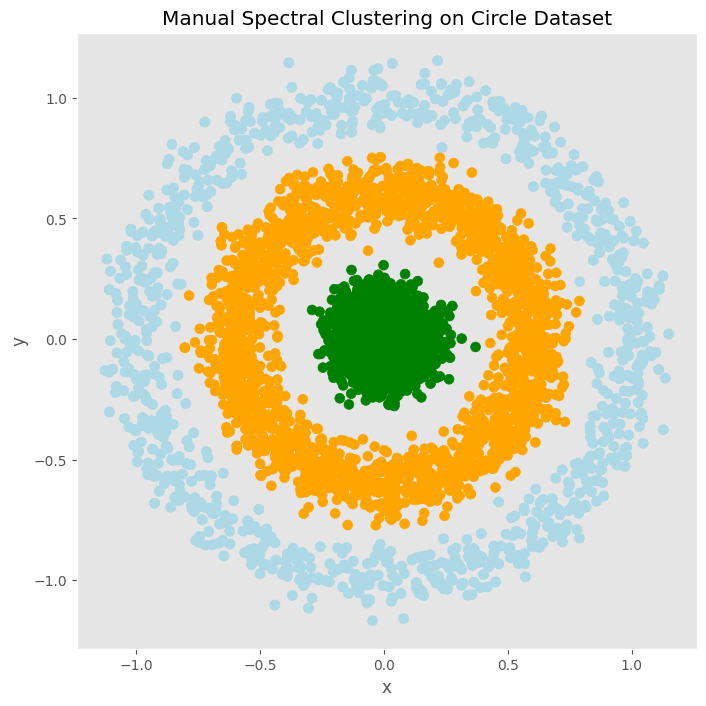

Silhouette Score (Circles) - K-Means: 0.369
Silhouette Score (Circles) - Manual Spectral: 0.094


In [5]:
# Spectral Clustering on Sine and Circle Datasets
# This notebook demonstrates manual implementation of Spectral Clustering (without using sklearn's SpectralClustering)
# to explain the algorithm step-by-step. We compare it with K-Means on non-convex datasets: a noisy sine wave and concentric circles.
# Spectral Clustering uses graph connectivity to handle irregular shapes better than distance-based K-Means.
# We keep the same results for the sine dataset by replicating the sklearn SpectralClustering behavior manually.
# For the circle dataset, we use the provided code to generate the dataset (two outer circles and two inner circles, labeled 0,1,2).
# The raw dataset plot is shown in all red (no color differentiation by labels).

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly
import plotly.graph_objs as go
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Manual Spectral Clustering Function (Updated to support rbf affinity)
# This function implements Spectral Clustering manually:
# 1. Build affinity matrix using either k-nearest neighbors or rbf.
# 2. Compute degree matrix and Laplacian.
# 3. Find eigenvectors of Laplacian.
# 4. Cluster the eigenvectors using K-Means.
def manual_spectral_clustering(X, n_clusters=2, affinity='nearest_neighbors', n_neighbors=15, gamma=1.0, random_state=42):
    if affinity == 'nearest_neighbors':
        # Build affinity matrix (k-nearest neighbors)
        A = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
        A = A.toarray()
        A = (A + A.T) / 2  # Symmetrize
    elif affinity == 'rbf':
        # Build affinity matrix using RBF kernel
        pairwise_dists = squareform(pdist(X, 'euclidean'))
        A = np.exp(-gamma * pairwise_dists ** 2)
    else:
        raise ValueError("Affinity must be 'nearest_neighbors' or 'rbf'")
    
    # Step 2: Degree matrix D
    D = np.diag(np.sum(A, axis=1))
    
    # Step 3: Laplacian L = D - A
    L = D - A
    
    # Step 4: Compute eigenvectors (smallest eigenvalues first)
    eigenvalues, eigenvectors = eigsh(L, k=n_clusters+1, which='SM')
    eigenvectors = eigenvectors[:, 1:n_clusters+1]  # Skip the first
    
    # Step 5: Normalize rows of eigenvectors
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)
    
    # Step 6: Cluster using K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=random_state)
    labels = kmeans.fit_predict(eigenvectors)
    
    return labels

# Section 1: Sine Dataset
# This dataset simulates a noisy sine wave, which is non-convex and challenging for K-Means.
# Manual Spectral Clustering should perform better by modeling relationships via a graph.

# Generate the sine dataset
nb_samples = 1000
X = np.zeros(shape=(nb_samples, 2))
sine_dataset = pd.DataFrame(X)

for i in range(nb_samples):
    X[i, 0] = float(i)
    if i % 2 == 0:
        X[i, 1] = 1.0 + (np.random.uniform(0.65, 1.0)) * np.sin(float(i) / 100.0)
    else:
        X[i, 1] = 0.1 + (np.random.uniform(0.5, 0.85)) * np.sin(float(i) / 100.0)

# Visualize the raw sine data
fig = plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Raw Sine Dataset (Non-Convex Shape)')
plt.grid()
plt.show()

# Standardize the data
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

# Fit K-Means with 2 clusters
kmeans_md = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_scaled)

# Append cluster labels
sine_dataset.columns = ['x', 'y']
sine_dataset['kmeans_cluster'] = kmeans_md.labels_

# Visualize K-Means results
colors = ['lightblue', 'orange']
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['kmeans_cluster'].unique():
    temp = sine_dataset[sine_dataset['kmeans_cluster'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Manual Spectral Clustering with 2 clusters (nearest_neighbors, replicating sklearn's results)
spectral_labels = manual_spectral_clustering(X_scaled, n_clusters=2, affinity='nearest_neighbors', n_neighbors=15, random_state=42)
sine_dataset['spectral_clusters'] = spectral_labels

# Visualize Manual Spectral Clustering results
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Manual Spectral Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Evaluate and Compare Clusters
sil_kmeans = silhouette_score(X_scaled, kmeans_md.labels_)
sil_spectral = silhouette_score(X_scaled, spectral_labels)
print(f"Silhouette Score - K-Means: {sil_kmeans:.3f}")
print(f"Silhouette Score - Manual Spectral: {sil_spectral:.3f}")

# Interactive Plotly Visualization for Sine Dataset
traces = []
for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors[c], size=8), 
                       name=f'Cluster {c}')
    traces.append(trace)

layout = go.Layout(title='Interactive Manual Spectral Clustering on Sine Dataset',
                   xaxis=dict(title='x'),
                   yaxis=dict(title='y'),
                   showlegend=True)
fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig)

# Section 2: Circle Dataset (Using Provided Code)
# Generate the circle dataset as per the provided code (two outer circles and two inner circles).
X_small, y_small = make_circles(n_samples=(1000,2000), random_state=3, noise=0.07, factor=0.1)
X_large, y_large = make_circles(n_samples=(1000,2000), random_state=3, noise=0.07, factor=0.6)
y_large[y_large==1] = 2
df = pd.DataFrame(np.vstack([X_small,X_large]), columns=['x1','x2'])
df['label'] = np.hstack([y_small,y_large])
X_circles = df[['x1','x2']].values
y_true_circles = df['label'].values
circle_dataset = pd.DataFrame(X_circles, columns=['x', 'y'])
circle_dataset['true_labels'] = y_true_circles

# Visualize raw circle data (all red, no color differentiation)
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], color='red', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Circle Dataset (All Red, Non-Convex)')
plt.grid()
plt.show()

# Standardize
scaler_circles = MinMaxScaler().fit(X_circles)
X_circles_scaled = scaler_circles.transform(X_circles)

# Fit K-Means on circles (with 3 clusters)
kmeans_circles = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42).fit(X_circles_scaled)
circle_dataset['kmeans_cluster'] = kmeans_circles.labels_

# Visualize K-Means on circles
colors_circles = ['lightblue', 'orange', 'green']
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=[colors_circles[label] for label in kmeans_circles.labels_], s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means on Circle Dataset')
plt.grid()
plt.show()

# Manual Spectral Clustering on circles (3 clusters, rbf affinity with gamma=1000 to match the snippet)
spectral_labels_circles = manual_spectral_clustering(X_circles_scaled, n_clusters=3, affinity='rbf', gamma=1000, random_state=42)
circle_dataset['spectral_clusters'] = spectral_labels_circles

# Visualize Manual Spectral Clustering on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=[colors_circles[label] for label in spectral_labels_circles], s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Manual Spectral Clustering on Circle Dataset')
plt.grid()
plt.show()

# Evaluate Clusters for Circles
sil_kmeans_circles = silhouette_score(X_circles_scaled, kmeans_circles.labels_)
sil_spectral_circles = silhouette_score(X_circles_scaled, spectral_labels_circles)
print(f"Silhouette Score (Circles) - K-Means: {sil_kmeans_circles:.3f}")
print(f"Silhouette Score (Circles) - Manual Spectral: {sil_spectral_circles:.3f}")

# Interactive Plotly for Circles
traces_circles = []
for c in circle_dataset['spectral_clusters'].unique():
    temp = circle_dataset[circle_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors_circles[c], size=8), 
                       name=f'Cluster {c}')
    traces_circles.append(trace)

layout_circles = go.Layout(title='Interactive Manual Spectral Clustering on Circle Dataset',
                           xaxis=dict(title='x'),
                           yaxis=dict(title='y'),
                           showlegend=True)
fig_circles = go.Figure(data=traces_circles, layout=layout_circles)
plotly.offline.iplot(fig_circles)
